<a href="https://colab.research.google.com/github/tsilva/sandbox-transformers/blob/main/HF_NLP_Course.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hugging Face NLP Course

This is a notebook on the [Hugging Face NLP Course](https://huggingface.co/learn/nlp-course/chapter1/1).

## 0. Setup

We will need to install the `transformers` library with the `sentencepiece` optional dependency since some of the models we're using use that library for tokenization.

In [ ]:
%pip install transformers[sentencepiece]

Note: you may need to restart the kernel to use updated packages.
  Using cached python_dotenv-1.0.1-py3-none-any.whl.metadata (23 kB)
Using cached python_dotenv-1.0.1-py3-none-any.whl (19 kB)
Note: you may need to restart the kernel to use updated packages.


In [12]:
%pip install python-dotenv

from dotenv import load_dotenv
load_dotenv()

Note: you may need to restart the kernel to use updated packages.


True

## 1. Transformer Models

### 1.1. Transformers, what can they do?

The following are some examples of using transformer models for performing different tasks, using the `pipeline` abstraction from `transformers`. This abstraction will select the most appropriate model for the specified task by default.



#### Sentiment analysis

Given one or more sentences, classify their sentiment. By default this pipeline currently uses `distilbert/distilbert-base-uncased-finetuned-sst-2-english` as it's default model.

In [13]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")
classifier(
    [
        "I've been waiting for a HuggingFace course my whole life.",
        "I hate this so much!",
        "It hurts so good!",
        "While the service was certainly unique, it left a lasting impression that I won’t forget anytime soon."
    ]
)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


[{'label': 'POSITIVE', 'score': 0.9598050713539124},
 {'label': 'NEGATIVE', 'score': 0.9994558691978455},
 {'label': 'NEGATIVE', 'score': 0.8600779175758362},
 {'label': 'POSITIVE', 'score': 0.9994854927062988}]

#### Zero-shot classification

In a `zero-shot-classification` task, a model must be able to classify the probability that an input should be labeled with each of the provided labels. These labels are not predefined, hence the zero-shot aspect. By default, this pipeline will use the `facebook/bart-large-mnli` model.

In [14]:
classifier = pipeline("zero-shot-classification")
classifier(
    "The ball curved beautifully into the top corner, leaving the goalkeeper with no chance.",
    candidate_labels=["sports", "art", "technology", "cooking", "nature"]
)

No model was supplied, defaulted to facebook/bart-large-mnli and revision d7645e1 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


{'sequence': 'The ball curved beautifully into the top corner, leaving the goalkeeper with no chance.',
 'labels': ['sports', 'technology', 'art', 'nature', 'cooking'],
 'scores': [0.35649970173835754,
  0.2944627106189728,
  0.2560218572616577,
  0.06628338992595673,
  0.026732269674539566]}

#### Text Generation

In a `text-generation` task, the model will add more tokens to the right of the provided sentence. In this particular example, let's ask it to generate to candidate sentence completions with a maximum length of 30. By default, this pipeline will use the `openai-community/gpt2` model.

In [6]:
generator = pipeline("text-generation")#, model="distilgpt2")
generator(
    "In this course, we will teach you how to",
    max_length=30,
    num_return_sequences=2, # Generate 2 candidate sentence completions with the provided input as the prefix
)

No model was supplied, defaulted to openai-community/gpt2 and revision 607a30d (https://huggingface.co/openai-community/gpt2).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

#### Mask Filling

The `mask-filling` task entails having the model predict the most likely tokens to be present in the location of the mask. This pipeline will use `distilbert/distilroberta-base` by default.

In [7]:
unmasker = pipeline("fill-mask")
unmasker("This course will teach you all about <mask> models.", top_k=2)

No model was supplied, defaulted to distilbert/distilroberta-base and revision fb53ab8 (https://huggingface.co/distilbert/distilroberta-base).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert/distilroberta-base were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

ReadTimeout: (ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: d5af27b5-c744-4cf6-b144-88e1938d656b)')

#### Named Entity Recognition

The `ner` task will identify words in text and group them according to their categories.

In [ ]:
ner = pipeline("ner", grouped_entities=True)
ner("My name is Sylvain and I work at Hugging Face in Brooklyn.")

#### Question Answering

With the `question-answering` pipeline, the user provides a context and a question, and the model will answer the question based on the context. This pipeline uses `distilbert/distilbert-base-cased-distilled-squad` by default.

In [ ]:
question_answerer = pipeline("question-answering")
question_answerer(
    question="Where do I work?",
    context="My name is Sylvain and I work at Hugging Face in Brooklyn",
)

#### Summarization

The `summarization` pipeline creates a summary of the provided text. This pipeline uses `sshleifer/distilbart-cnn-12-6` by default.

In [ ]:
summarizer = pipeline("summarization")
summarizer(
    """
    America has changed dramatically during recent years. Not only has the number of
    graduates in traditional engineering disciplines such as mechanical, civil,
    electrical, chemical, and aeronautical engineering declined, but in most of
    the premier American universities engineering curricula now concentrate on
    and encourage largely the study of engineering science. As a result, there
    are declining offerings in engineering subjects dealing with infrastructure,
    the environment, and related issues, and greater concentration on high
    technology subjects, largely supporting increasingly complex scientific
    developments. While the latter is important, it should not be at the expense
    of more traditional engineering.

    Rapidly developing economies such as China and India, as well as other
    industrial countries in Europe and Asia, continue to encourage and advance
    the teaching of engineering. Both China and India, respectively, graduate
    six and eight times as many traditional engineers as does the United States.
    Other industrial countries at minimum maintain their output, while America
    suffers an increasingly serious decline in the number of engineering graduates
    and a lack of well-educated engineers.
"""
)


#### Translation

The `translation` pipeline translates text from one language to another. You will need to specify a model, otherwise the pipeline won't know which one to select because it doesn't know which languages it's translating.

In [ ]:
translator = pipeline("translation", model="Helsinki-NLP/opus-mt-fr-en")
translator("Ce cours est produit par Hugging Face.")

### Feature Extraction

The `feature-extraction` pipeline converts sentences to embeddings. This pipeline uses `distilbert/distilbert-base-cased` by default.

In [ ]:
feature_extractor = pipeline("feature-extraction")
feature_extractor([
    "Woodpecker",
    "How much wood would a woodchuck chuck if a woodchuck could chuck wood?",
    "Soccer"
])[0]

### 1.2. How do Transformers work?

GPT-like (also called auto-regressive Transformer models)
BERT-like (also called auto-encoding Transformer models)
BART/T5-like (also called sequence-to-sequence Transformer models)

Causal Language Modeling: Predict next word based on previous N Words

Masked Language Modeling: Predict masked word in sequence of words

Encoder-only models: Good for tasks that require understanding of the input, such as sentence classification and named entity recognition.
Decoder-only models: Good for generative tasks such as text generation.
Encoder-decoder models or sequence-to-sequence models: Good for generative tasks that require an input, such as translation or summarization.

### 1.3. Encoder Models

BERT is an encoder-only architecture. Here the self-attention mechanisms nudges the embedding of each word to be influenced by surrounding words.

### 1.4. Decoder Models

Decoder models use only the decoder of a Transformer model. At each stage, for a given word the attention layers can only access the words positioned before it in the sentence. These models are often called auto-regressive models.

Decoders self-attention mechanism is different from encoders. These use masked self-attention, where they only have access to words in one side, typically previous words on left. These models are good for text generation and GPT-2 is an example of a decoder only model.

### 1.5. Encoder-Decoder Models

Encoder-decoder models (also called sequence-to-sequence models) use both parts of the Transformer architecture. At each stage, the attention layers of the encoder can access all the words in the initial sentence, whereas the attention layers of the decoder can only access the words positioned before a given word in the input.

Sequence-to-sequence models are best suited for tasks revolving around generating new sentences depending on a given input, such as summarization, translation, or generative question answering.

Representatives of this family of models include: BART and T5

### 1.6. Bias and Limitations

https://huggingface.co/learn/nlp-course/chapter1/8?fw=pt

In [ ]:
unmasker = pipeline("fill-mask", model="bert-base-uncased")
result = unmasker("This man works as a [MASK].")
result

Model	Examples	Tasks
Encoder	ALBERT, BERT, DistilBERT, ELECTRA, RoBERTa	Sentence classification, named entity recognition, extractive question answering
Decoder	CTRL, GPT, GPT-2, Transformer XL	Text generation
Encoder-decoder	BART, T5, Marian, mBART	Summarization, translation, generative question answering


---

## 2. Using Transformers

### 2.1. Behind the Pipeline

In [14]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")
classifier(
    [
        "I've been waiting for a HuggingFace course my whole life.",
        "I hate this so much!",
    ]
)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0


[{'label': 'POSITIVE', 'score': 0.9598046541213989},
 {'label': 'NEGATIVE', 'score': 0.9994558691978455}]

In [15]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [16]:
raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.",
    "I hate this so much!",
]
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")
inputs.keys(), inputs

(dict_keys(['input_ids', 'attention_mask']),
 {'input_ids': tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
           2607,  2026,  2878,  2166,  1012,   102],
         [  101,  1045,  5223,  2023,  2061,  2172,   999,   102,     0,     0,
              0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])})

In [17]:
inputs['input_ids'].shape, inputs['input_ids']

(torch.Size([2, 16]),
 tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
           2607,  2026,  2878,  2166,  1012,   102],
         [  101,  1045,  5223,  2023,  2061,  2172,   999,   102,     0,     0,
              0,     0,     0,     0,     0,     0]]))

In [18]:
inputs['attention_mask'].shape, inputs['attention_mask']

(torch.Size([2, 16]),
 tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]]))

The attention mask indicates which tokens it should pay attention to. Zeros are placed in the padded tokens so the transformer can ignore these tokens.

In [19]:
from transformers import AutoModel

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModel.from_pretrained(checkpoint)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [20]:
outputs = model(**inputs)
print(outputs.last_hidden_state.shape)

torch.Size([2, 16, 768])


torch.Size([2, 16, 768]) because they were two sentences, each tokenized into 16 tokens (short sentence is padded), and each token represented as a tensor with dimension 768. If sentences were larger than the model supported, they would be truncated. return_tensors="pt" is used to return pytorch tensors.

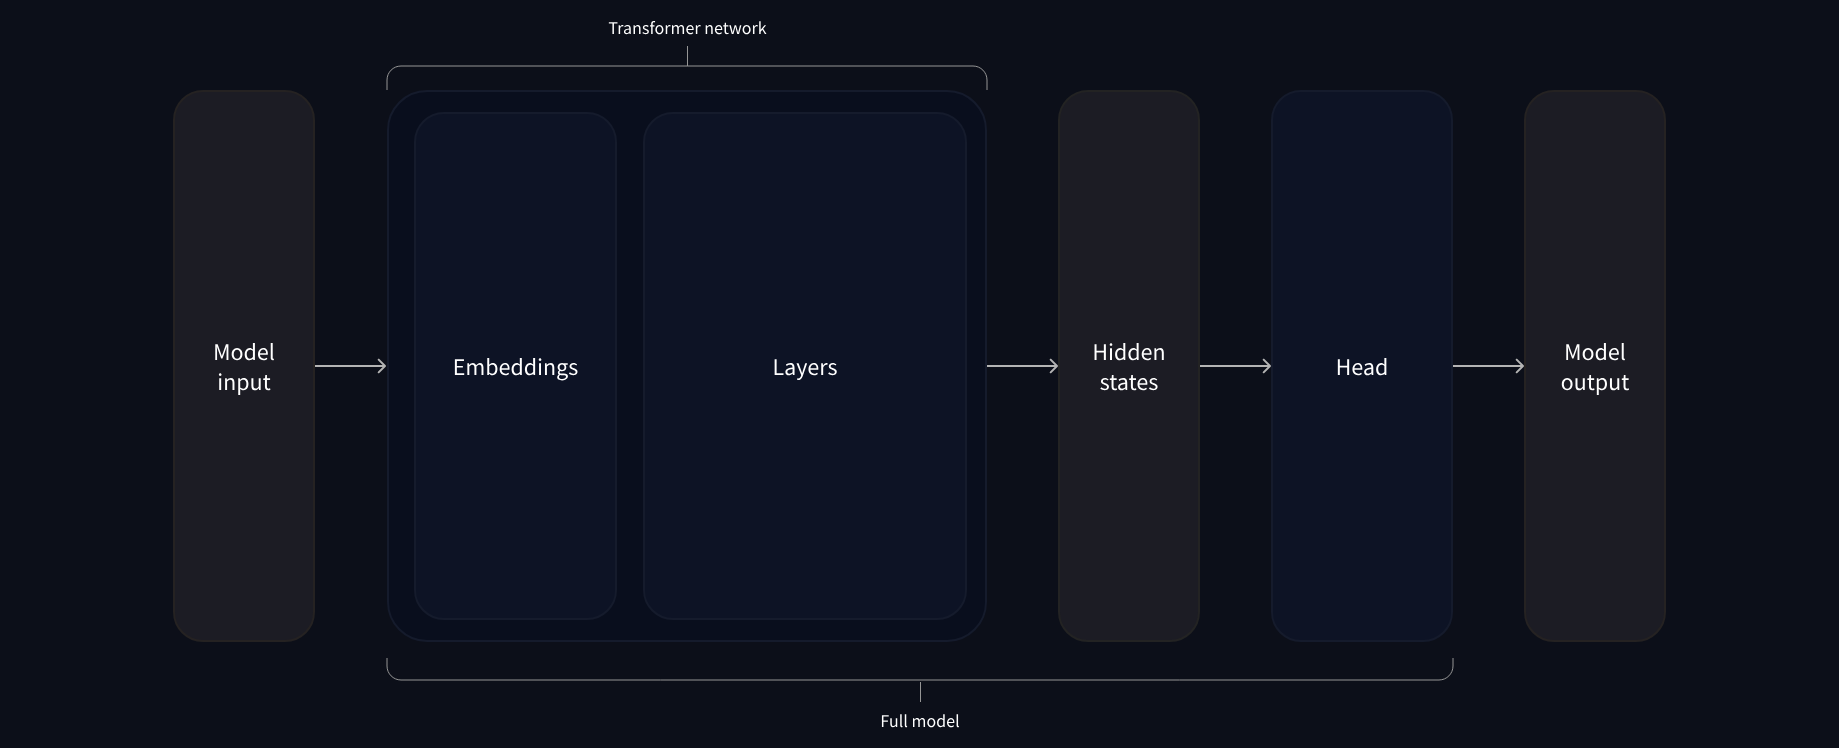

In [21]:
from transformers import AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(**inputs)
print(outputs.logits.shape)

torch.Size([2, 2])


Since we have just two sentences and two labels, the result we get from our model is of shape 2 x 2.

In [22]:
print(outputs.logits)

tensor([[-1.5607,  1.6123],
        [ 4.1692, -3.3464]], grad_fn=<AddmmBackward0>)


In [23]:
import torch

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)

tensor([[4.0195e-02, 9.5980e-01],
        [9.9946e-01, 5.4418e-04]], grad_fn=<SoftmaxBackward0>)


In [24]:
model.config.id2label

{0: 'NEGATIVE', 1: 'POSITIVE'}

Now we can conclude that the model predicted the following:

First sentence: NEGATIVE: 0.0402, POSITIVE: 0.9598
Second sentence: NEGATIVE: 0.9995, POSITIVE: 0.0005

### 2.2. Models

AutoModel automatically instantiates the appropriate model for the specified checkpoint. But you can do it directly:

In [25]:
from transformers import BertConfig, BertModel

# Building the config
config = BertConfig()

# Building the model from the config
model = BertModel(config)
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [26]:
print(config)

BertConfig {
  "_attn_implementation_autoset": true,
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.47.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [27]:
from transformers import BertModel

model = BertModel.from_pretrained("bert-base-cased")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [28]:
model.save_pretrained("directory_on_my_computer")

In [29]:
!ls directory_on_my_computer

config.json  model.safetensors


model.save_pretrained("directory_on_my_computer")

In [30]:
sequences = ["Hello!", "Cool.", "Nice!"]

In [31]:
encoded_sequences = [
    [101, 7592, 999, 102],
    [101, 4658, 1012, 102],
    [101, 3835, 999, 102],
]

In [32]:
import torch

model_inputs = torch.tensor(encoded_sequences)

In [33]:
output = model(model_inputs)
output

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 4.4496e-01,  4.8276e-01,  2.7797e-01,  ..., -5.4032e-02,
           3.9393e-01, -9.4770e-02],
         [ 2.4943e-01, -4.4093e-01,  8.1772e-01,  ..., -3.1917e-01,
           2.2992e-01, -4.1172e-02],
         [ 1.3668e-01,  2.2518e-01,  1.4502e-01,  ..., -4.6915e-02,
           2.8224e-01,  7.5566e-02],
         [ 1.1789e+00,  1.6738e-01, -1.8187e-01,  ...,  2.4671e-01,
           1.0441e+00, -6.1972e-03]],

        [[ 3.6436e-01,  3.2464e-02,  2.0258e-01,  ...,  6.0110e-02,
           3.2451e-01, -2.0996e-02],
         [ 7.1866e-01, -4.8725e-01,  5.1740e-01,  ..., -4.4012e-01,
           1.4553e-01, -3.7545e-02],
         [ 3.3223e-01, -2.3271e-01,  9.4876e-02,  ..., -2.5268e-01,
           3.2172e-01,  8.1085e-04],
         [ 1.2523e+00,  3.5754e-01, -5.1320e-02,  ..., -3.7840e-01,
           1.0526e+00, -5.6255e-01]],

        [[ 2.4042e-01,  1.4718e-01,  1.2110e-01,  ...,  7.6062e-02,
           3.3564e-01,  2

### 2.4. Tokenizers

- word-based
- character-based
- subword-based

word-based:
- split on spaces
- split on punctuation

A vocabulary is the total number of tokens the tokenizer can generate. Each word gets assigned an ID, starting from 0 and going up to the size of the vocabulary. The model uses these IDs to identify each word. Unknown tokens are represented as `[UNK]` or `<unk>`.


Word-based tokenizers require a large vocabulary (eg: there are 500k words in the English language).

Character-based tokenizers assign an ID to each character, which makes the vocabulary much smaller and makes unknown tokens unlikely.

However, characters carry little meaning when compared to words, and tokenizing by characters will make the input ultimately be converted to a much bigger tensor.

NOTE: Character-level tokenizers may be worthwhile in some languages, like in Chinese, where each character carries a lot of meaning.

Subword-based tokenizers have the pros of word and character-based tokenizers with few cons. They are able to form a much smaller vocabulary than word-based tokenizers while still making sure each token carries enough meaning. The way this is done is that frequent words get their own token, and infrequent are split into multiple tokens in order to maximize their frequency in the corpus. For example, modern may be more frequent than modernization in a text corpus. So splitting "modernization" into "modern" and "ization" maximizes their frequency, as "ization" is used as an ending to multiple words, and has a specific meaning when attached to each word. The model can still understand that when these two tokens "modern" and "ization" appear together, it means that "modern" 's meaning is to be nudged to add "ization"'s meaning, making it have the meaning of "modernization".

There are more tokenization strategies, eg:

Byte-level BPE, as used in GPT-2
WordPiece, as used in BERT
SentencePiece or Unigram, as used in several multilingual models

In [34]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [35]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [36]:
tokenizer("Using a Transformer network is simple")

{'input_ids': [101, 7993, 170, 13809, 23763, 2443, 1110, 3014, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

Translating text to numbers is known as encoding. Encoding is done in a two-step process: the tokenization, followed by the conversion to input IDs.

As we’ve seen, the first step is to split the text into words (or parts of words, punctuation symbols, etc.), usually called tokens. There are multiple rules that can govern that process, which is why we need to instantiate the tokenizer using the name of the model, to make sure we use the same rules that were used when the model was pretrained.

In [44]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

sequence = "Using a Transformer network is simple"
tokens = tokenizer.tokenize(sequence)

print(tokens)

['Using', 'a', 'Trans', '##former', 'network', 'is', 'simple']


In [43]:
ids = tokenizer.convert_tokens_to_ids(tokens)

print(ids)

[1045, 1005, 2310, 2042, 3403, 2005, 1037, 17662, 12172, 2607, 2026, 2878, 2166, 1012]


In [45]:
decoded_string = tokenizer.decode([7993, 170, 11303, 1200, 2443, 1110, 3014])
print(decoded_string)

Using a transformer network is simple


### 2.5. Handling multiple sequences

In [46]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

sequence = "I've been waiting for a HuggingFace course my whole life."

tokens = tokenizer.tokenize(sequence)
ids = tokenizer.convert_tokens_to_ids(tokens)
input_ids = torch.tensor(ids)
# This line will fail.
model(input_ids)

IndexError: too many indices for tensor of dimension 1

In [47]:
tokenized_inputs = tokenizer(sequence, return_tensors="pt")
print(tokenized_inputs["input_ids"])

tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102]])


In [48]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

sequence = "I've been waiting for a HuggingFace course my whole life."

tokens = tokenizer.tokenize(sequence)
ids = tokenizer.convert_tokens_to_ids(tokens)

input_ids = torch.tensor([ids])
print("Input IDs:", input_ids)

output = model(input_ids)
print("Logits:", output.logits)

Input IDs: tensor([[ 1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,  2607,
          2026,  2878,  2166,  1012]])
Logits: tensor([[-2.7276,  2.8789]], grad_fn=<AddmmBackward0>)


In [49]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

sequence1_ids = [[200, 200, 200]]
sequence2_ids = [[200, 200]]
batched_ids = [
    [200, 200, 200],
    [200, 200, tokenizer.pad_token_id],
]

print(model(torch.tensor(sequence1_ids)).logits)
print(model(torch.tensor(sequence2_ids)).logits)
print(model(torch.tensor(batched_ids)).logits)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


tensor([[ 1.5694, -1.3895]], grad_fn=<AddmmBackward0>)
tensor([[ 0.5803, -0.4125]], grad_fn=<AddmmBackward0>)
tensor([[ 1.5694, -1.3895],
        [ 1.3374, -1.2163]], grad_fn=<AddmmBackward0>)


Notice how the predictions on the batched ids were different from the invidiual predictions. This is because the model attended to the padding tokens. To get the same result, we need to provide an attention mask to tell the model which tokens to ignore:

In [50]:
batched_ids = [
    [200, 200, 200],
    [200, 200, tokenizer.pad_token_id],
]

attention_mask = [
    [1, 1, 1],
    [1, 1, 0],
]



print(model(torch.tensor(sequence1_ids)).logits)
print(model(torch.tensor(sequence2_ids)).logits)
outputs = model(torch.tensor(batched_ids), attention_mask=torch.tensor(attention_mask))
print(outputs.logits)

tensor([[ 1.5694, -1.3895]], grad_fn=<AddmmBackward0>)
tensor([[ 0.5803, -0.4125]], grad_fn=<AddmmBackward0>)
tensor([[ 1.5694, -1.3895],
        [ 0.5803, -0.4125]], grad_fn=<AddmmBackward0>)


When sequences are bigger than the model context length, use a different model or truncate sequences. eg: `sequence = sequence[:max_sequence_length]`

### 2.6. Putting it all together

In [51]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

sequence = "I've been waiting for a HuggingFace course my whole life."

model_inputs = tokenizer(sequence)
model_inputs

{'input_ids': [101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 17662, 12172, 2607, 2026, 2878, 2166, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [53]:
sequence = "I've been waiting for a HuggingFace course my whole life."

model_inputs = tokenizer(sequence)
model_inputs

{'input_ids': [101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 17662, 12172, 2607, 2026, 2878, 2166, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [54]:
sequences = ["I've been waiting for a HuggingFace course my whole life.", "So have I!"]

model_inputs = tokenizer(sequences)
model_inputs

{'input_ids': [[101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 17662, 12172, 2607, 2026, 2878, 2166, 1012, 102], [101, 2061, 2031, 1045, 999, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]}

In [55]:
# Will pad the sequences up to the maximum sequence length
model_inputs_1 = tokenizer(sequences, padding="longest")

# Will pad the sequences up to the model max length
# (512 for BERT or DistilBERT)
model_inputs_2 = tokenizer(sequences, padding="max_length")

# Will pad the sequences up to the specified max length
model_inputs_3 = tokenizer(sequences, padding="max_length", max_length=8)

model_inputs_1, model_inputs_2, model_inputs_3

({'input_ids': [[101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 17662, 12172, 2607, 2026, 2878, 2166, 1012, 102], [101, 2061, 2031, 1045, 999, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]},
 {'input_ids': [[101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 17662, 12172, 2607, 2026, 2878, 2166, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [56]:
sequences = ["I've been waiting for a HuggingFace course my whole life.", "So have I!"]

# Returns PyTorch tensors
model_inputs_pt = tokenizer(sequences, padding=True, return_tensors="pt")

# Returns TensorFlow tensors
model_inputs_tf = tokenizer(sequences, padding=True, return_tensors="tf")

# Returns NumPy arrays
model_inputs_np = tokenizer(sequences, padding=True, return_tensors="np")

model_inputs_pt, model_inputs_tf, model_inputs_np

({'input_ids': tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
           2607,  2026,  2878,  2166,  1012,   102],
         [  101,  2061,  2031,  1045,   999,   102,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])},
 {'input_ids': <tf.Tensor: shape=(2, 16), dtype=int32, numpy=
 array([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662,
         12172,  2607,  2026,  2878,  2166,  1012,   102],
        [  101,  2061,  2031,  1045,   999,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 16), dtype=int32, numpy=
 array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>},
 {'input_ids': array([[  101,  1045,  1005

In [57]:
sequence = "I've been waiting for a HuggingFace course my whole life."

model_inputs = tokenizer(sequence)
print(model_inputs["input_ids"])

tokens = tokenizer.tokenize(sequence)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

[101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 17662, 12172, 2607, 2026, 2878, 2166, 1012, 102]
[1045, 1005, 2310, 2042, 3403, 2005, 1037, 17662, 12172, 2607, 2026, 2878, 2166, 1012]


In [58]:
print(tokenizer.decode(model_inputs["input_ids"]))
print(tokenizer.decode(ids))

[CLS] i've been waiting for a huggingface course my whole life. [SEP]
i've been waiting for a huggingface course my whole life.


In [59]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
sequences = ["I've been waiting for a HuggingFace course my whole life.", "So have I!"]

tokens = tokenizer(sequences, padding=True, truncation=True, return_tensors="pt")
output = model(**tokens)
output

SequenceClassifierOutput(loss=None, logits=tensor([[-1.5607,  1.6123],
        [-3.6183,  3.9137]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

Great job following the course up to here! To recap, in this chapter you:

Learned the basic building blocks of a Transformer model.
Learned what makes up a tokenization pipeline.
Saw how to use a Transformer model in practice.
Learned how to leverage a tokenizer to convert text to tensors that are understandable by the model.
Set up a tokenizer and a model together to get from text to predictions.
Learned the limitations of input IDs, and learned about attention masks.
Played around with versatile and configurable tokenizer methods.

## 3. Fine-tuning a Pretrained Model

In [60]:
import torch
from transformers import AdamW, AutoTokenizer, AutoModelForSequenceClassification

# Same as before
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
sequences = [
    "I've been waiting for a HuggingFace course my whole life.",
    "This course is amazing!",
]
batch = tokenizer(sequences, padding=True, truncation=True, return_tensors="pt")

# This is new
batch["labels"] = torch.tensor([1, 1])

optimizer = AdamW(model.parameters())
loss = model(**batch).loss
loss.backward()
optimizer.step()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [61]:
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_syste

In [62]:
from datasets import load_dataset

raw_datasets = load_dataset("glue", "mrpc")
raw_datasets

README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/649k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/75.7k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/308k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/408 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1725 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})

In [63]:
raw_train_dataset = raw_datasets["train"]
raw_train_dataset[0]

{'sentence1': 'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .',
 'sentence2': 'Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .',
 'label': 1,
 'idx': 0}

In [64]:
raw_train_dataset.features

{'sentence1': Value(dtype='string', id=None),
 'sentence2': Value(dtype='string', id=None),
 'label': ClassLabel(names=['not_equivalent', 'equivalent'], id=None),
 'idx': Value(dtype='int32', id=None)}

In [65]:
from transformers import AutoTokenizer

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenized_sentences_1 = tokenizer(raw_datasets["train"]["sentence1"])
tokenized_sentences_2 = tokenizer(raw_datasets["train"]["sentence2"])

In [66]:
inputs = tokenizer("This is the first sentence.", "This is the second one.")
inputs

{'input_ids': [101, 2023, 2003, 1996, 2034, 6251, 1012, 102, 2023, 2003, 1996, 2117, 2028, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [67]:
tokenizer.convert_ids_to_tokens(inputs["input_ids"])

['[CLS]',
 'this',
 'is',
 'the',
 'first',
 'sentence',
 '.',
 '[SEP]',
 'this',
 'is',
 'the',
 'second',
 'one',
 '.',
 '[SEP]']

In [68]:
{x:y for x,y in zip(inputs["input_ids"], tokenizer.convert_ids_to_tokens(inputs["input_ids"]))}

{101: '[CLS]',
 2023: 'this',
 2003: 'is',
 1996: 'the',
 2034: 'first',
 6251: 'sentence',
 1012: '.',
 102: '[SEP]',
 2117: 'second',
 2028: 'one'}

In [69]:
tokenized_dataset = tokenizer(
    raw_datasets["train"]["sentence1"],
    raw_datasets["train"]["sentence2"],
    padding=True,
    truncation=True,
    return_tensors="pt"
)
input_ids = tokenized_dataset["input_ids"]
input_ids.shape

torch.Size([3668, 103])

It's best to use the map function with tokenize function to make use of the fact that datasets are in apache arrow format (otherwise we would need to make sure that the dataset fits RAM).

In [70]:
def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1725
    })
})

In [71]:
raw_datasets["train"].features, tokenized_datasets["train"].features

({'sentence1': Value(dtype='string', id=None),
  'sentence2': Value(dtype='string', id=None),
  'label': ClassLabel(names=['not_equivalent', 'equivalent'], id=None),
  'idx': Value(dtype='int32', id=None)},
 {'sentence1': Value(dtype='string', id=None),
  'sentence2': Value(dtype='string', id=None),
  'label': ClassLabel(names=['not_equivalent', 'equivalent'], id=None),
  'idx': Value(dtype='int32', id=None),
  'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
  'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
  'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)})

Notice that the tokenization process added new fields to the dataset.

The function that is responsible for putting together samples inside a batch is called a collate function.

In [72]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
data_collator

DataCollatorWithPadding(tokenizer=BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
), padding=True, max_length=None, pad_to_multiple_of=None, return_tensors='pt')

In [73]:
samples = tokenized_datasets["train"][:8]
samples = {k: v for k, v in samples.items() if k not in ["idx", "sentence1", "sentence2"]}
[len(x) for x in samples["input_ids"]]

[50, 59, 47, 67, 59, 50, 62, 32]

In [74]:
batch = data_collator(samples)
{k: v.shape for k, v in batch.items()}

{'input_ids': torch.Size([8, 67]),
 'token_type_ids': torch.Size([8, 67]),
 'attention_mask': torch.Size([8, 67]),
 'labels': torch.Size([8])}

In [75]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

raw_datasets = load_dataset("glue", "mrpc")
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)


tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

In [76]:
from transformers import TrainingArguments

training_args = TrainingArguments("test-trainer")

In [77]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [78]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator, # defaultgs to  DataCollatorWithPadding if not provided
    tokenizer=tokenizer,
)

<ipython-input-78-f264720bd6ef>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [80]:
trainer.train()

Step,Training Loss


Error: You must call wandb.init() before wandb.log()

In [ ]:
predictions = trainer.predict(tokenized_datasets["validation"])
print(predictions.predictions.shape, predictions.label_ids.shape)

In [ ]:
import numpy as np

preds = np.argmax(predictions.predictions, axis=-1)

In [ ]:
preds

In [ ]:
!pip install evaluate

In [ ]:
import evaluate

metric = evaluate.load("glue", "mrpc")
metric.compute(predictions=preds, references=predictions.label_ids)

In [ ]:
def compute_metrics(eval_preds):
    metric = evaluate.load("glue", "mrpc")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
training_args = TrainingArguments("test-trainer", evaluation_strategy="epoch")
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:

trainer.train()

Now a full training

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

raw_datasets = load_dataset("glue", "mrpc")
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)


tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
tokenized_datasets = tokenized_datasets.remove_columns(["sentence1", "sentence2", "idx"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=8, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], batch_size=8, collate_fn=data_collator
)

In [ ]:
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

In [ ]:
outputs = model(**batch)
print(outputs.loss, outputs.logits.shape)

In [ ]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

In [ ]:
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

In [ ]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

In [ ]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

In [ ]:
import evaluate

metric = evaluate.load("glue", "mrpc")
model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

Now with "accelerate":

In [ ]:
from transformers import AdamW, AutoModelForSequenceClassification, get_scheduler

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
optimizer = AdamW(model.parameters(), lr=3e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

In [ ]:
from accelerate import Accelerator
from transformers import AdamW, AutoModelForSequenceClassification, get_scheduler

accelerator = Accelerator()

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
optimizer = AdamW(model.parameters(), lr=3e-5)

train_dl, eval_dl, model, optimizer = accelerator.prepare(
    train_dataloader, eval_dataloader, model, optimizer
)

num_epochs = 3
num_training_steps = num_epochs * len(train_dl)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dl:
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)